In [27]:
import numpy as np
import pandas as pd
import os
bird_df = pd.read_csv("../data/birds.csv")

In [28]:
bird_df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [29]:
#set up directories for train, test, and validation data
dir_train = "../data/train/"
dir_test = "../data/test/"
dir_v = "../data/valid/"

In [30]:
classes = os.listdir(dir_train)
n_classes = len(classes)
print("Total classes: ", n_classes)

Total classes:  525


In [31]:
#show some images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def bird_image(direct, classes):
    path = direct + classes
    random_image = random.sample(os.listdir(path), 1)

    img = mpimg.imread(path + "/" + random_image[0])
    plt.imshow(img)
    plt.axis('off')
    plt.title(classes)
    print("Image shape: ", img.shape)
    plt.show()
    return img

Image shape:  (224, 224, 3)


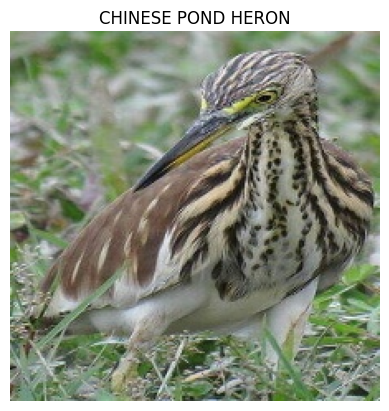

In [32]:
#show a random image with a random class
img = bird_image(dir_train, random.choice(classes))

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
#create generators
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)
valid_image_generator = ImageDataGenerator(rescale=1./255)

#set up generators
batch_size = 32
img_height = 224
img_width = 224
channels = 3

train_data = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=dir_train,
                                                              shuffle=True,
                                                              target_size=(img_height, img_width),
                                                              class_mode='categorical')

test_data = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                                directory=dir_test,
                                                                shuffle=False,
                                                                target_size=(img_height, img_width),
                                                                class_mode='categorical')

val_data = valid_image_generator.flow_from_directory(batch_size=batch_size,
                                                                directory=dir_v,
                                                                shuffle=False,
                                                                target_size=(img_height, img_width),
                                                                class_mode='categorical')

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [35]:
#create a model
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, channels)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
])


In [36]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 64)       

Epoch 1/10
2645/2645 [==============================] - 61s 23ms/step - loss: 4.1980 - accuracy: 0.1968 - val_loss: 2.5312 - val_accuracy: 0.4331
Epoch 2/10
2645/2645 [==============================] - 58s 22ms/step - loss: 2.0724 - accuracy: 0.5358 - val_loss: 2.0743 - val_accuracy: 0.5341
Epoch 3/10
2645/2645 [==============================] - 56s 21ms/step - loss: 0.9387 - accuracy: 0.7649 - val_loss: 2.3823 - val_accuracy: 0.5215
Epoch 4/10
2645/2645 [==============================] - 58s 22ms/step - loss: 0.3322 - accuracy: 0.9081 - val_loss: 3.1713 - val_accuracy: 0.5032


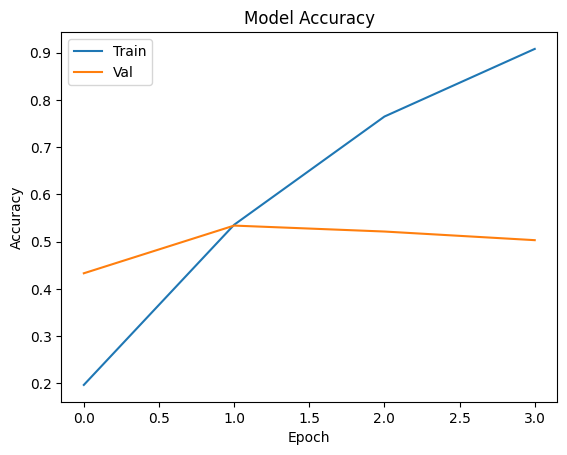

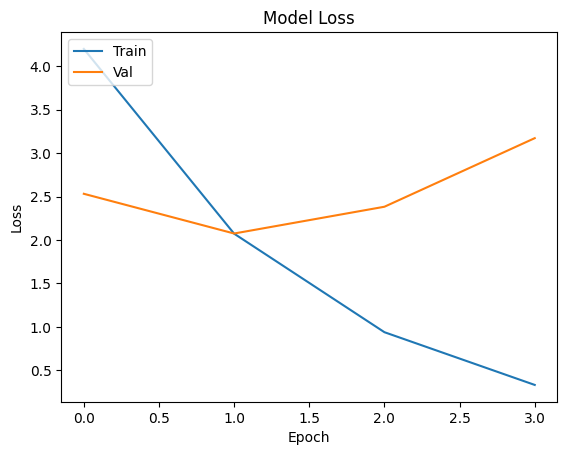

In [38]:
#prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

#train model
epochs = 10
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stopping]
)
#plot accuracy and loss
def plot_accuracy_loss(history):
    #plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    #plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_accuracy_loss(history)

In [39]:
#evaluate model
loss, acc = model.evaluate(test_data)
print("Accuracy: ", acc)
print("Loss: ", loss)

83/83 [==============================] - 2s 22ms/step - loss: 2.8706 - accuracy: 0.5394
Accuracy:  0.5394285917282104
Loss:  2.870605230331421
